In [104]:
from torch import nn
from tqdm import tqdm
from torchvision import models
from torchsummary import summary
from typing import Tuple, List, Dict
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import os
import json
import wfdb
import torch
import random
import ecg_plot
import pandas as pd 
import numpy as np
import seaborn as sns
import data_utils.preprocces
import torch.nn.functional as F
import matplotlib.pyplot as plt
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [8]:
from data.example_physionet import load_raw_data
from data_utils.preprocces import preprocess_data, compute_codes_count, get_abbrevations, label_column
from data_utils.load_split_data import load_data, train_test_split_by_captions, train_test_split_dataset

In [9]:
df = pd.read_csv('data/ptbxl_database.csv', encoding='UTF-8')
scp_statements = pd.read_csv('data/scp_statements.csv', encoding='UTF-8')

In [10]:
df.head(5)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [11]:
scp_statements.head(5)

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [12]:
print(f"Размер scp_statements = {scp_statements.shape}")
print(f"Размер ptbxl_database = {df.shape}")

Размер scp_statements = (71, 13)
Размер ptbxl_database = (21799, 28)


In [13]:
scp_statements, prepared_df = preprocess_data(scp_statements, df)

In [14]:
codes, sinus, not_sinus = get_abbrevations(scp_statements)
print(f"Список всех аббревиатур кодов: {codes}")
print(f"Список кодов с синусовой аритмией: {sinus}")
print(f"Список остальных кодов: {not_sinus}")

Список всех аббревиатур кодов: ['SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR', 'BIGU', 'AFLT', 'SVTAC', 'PSVT', 'TRIGU']
Список кодов с синусовой аритмией: ['SR', 'STACH', 'SARRH', 'SBRAD']
Список остальных кодов: ['SVARR', 'AFIB', 'PSVT', 'AFLT', 'BIGU', 'PACE', 'TRIGU', 'SVTAC']


In [15]:
codes_distribution = compute_codes_count(df)

In [16]:
fig,ax = plt.subplots()
fig.set_size_inches(5, 7)
ax.set_title('Top 20 Most Common Diagnoses')
ax.set_xlabel('Number of Incidences')
ax.set_ylabel('Diagnosis Abbreviation')
ax.hist(list(codes_distribution.keys()), list(codes_distribution.values()))

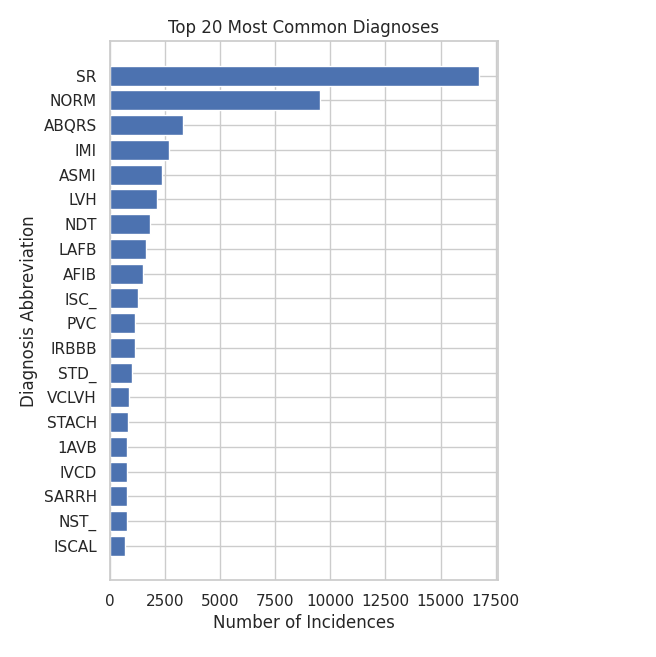

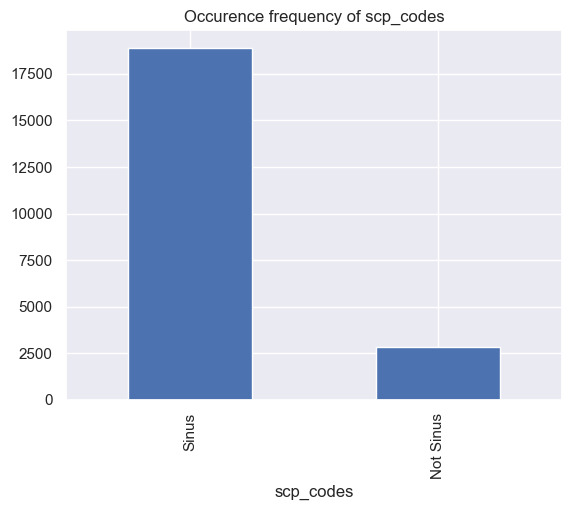

In [17]:
value_counts = df['scp_codes'].value_counts()
cdf = value_counts.drop('Undefined')
cdf.plot(kind='bar')
plt.title('Occurence frequency of scp_codes')
plt.show()

In [18]:
prepared_df.head(5)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [19]:
path = 'data/'
X = load_data(prepared_df, path)

100%|████████████████████████████████████████████████████████████████████████████| 21712/21712 [04:59<00:00, 72.42it/s]


In [20]:
encoder = LabelEncoder()
y = encoder.fit_transform(prepared_df['scp_codes'])

In [21]:
def plot_signal(signal_data, length=5000):
    params = {0: "Not sinus", 1: "Sinus"}
    fig, axs = plt.subplots(12, 1, figsize=(12, 9))
    for i, sig_data in enumerate(signal_data.T):
        if i == 0:
            axs[i].set_title(f"{params[y[0]]} rhythm")
        axs[i].plot(sig_data[:length])
    plt.show()

def plot_ecg(signal_data):
    signal = signal_data.T
    ecg_plot.plot(signal, title="ECG Signal, Record 1 - SINUS", show_lead_name=True)
    plt.show()

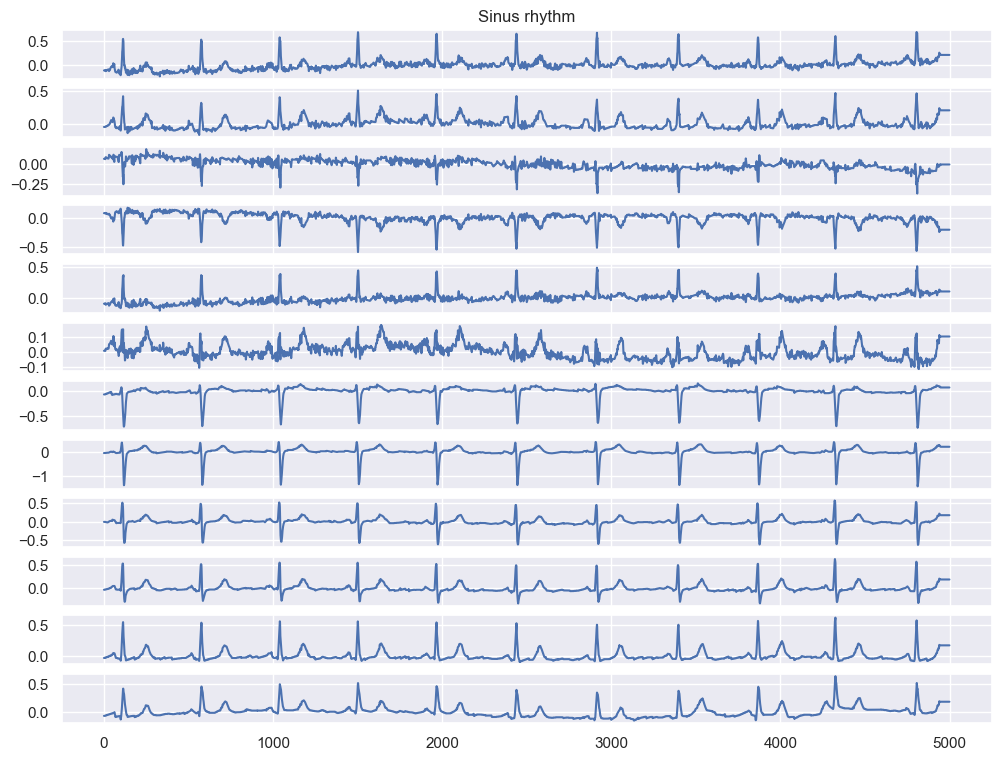

In [22]:
plot_signal(X[0])

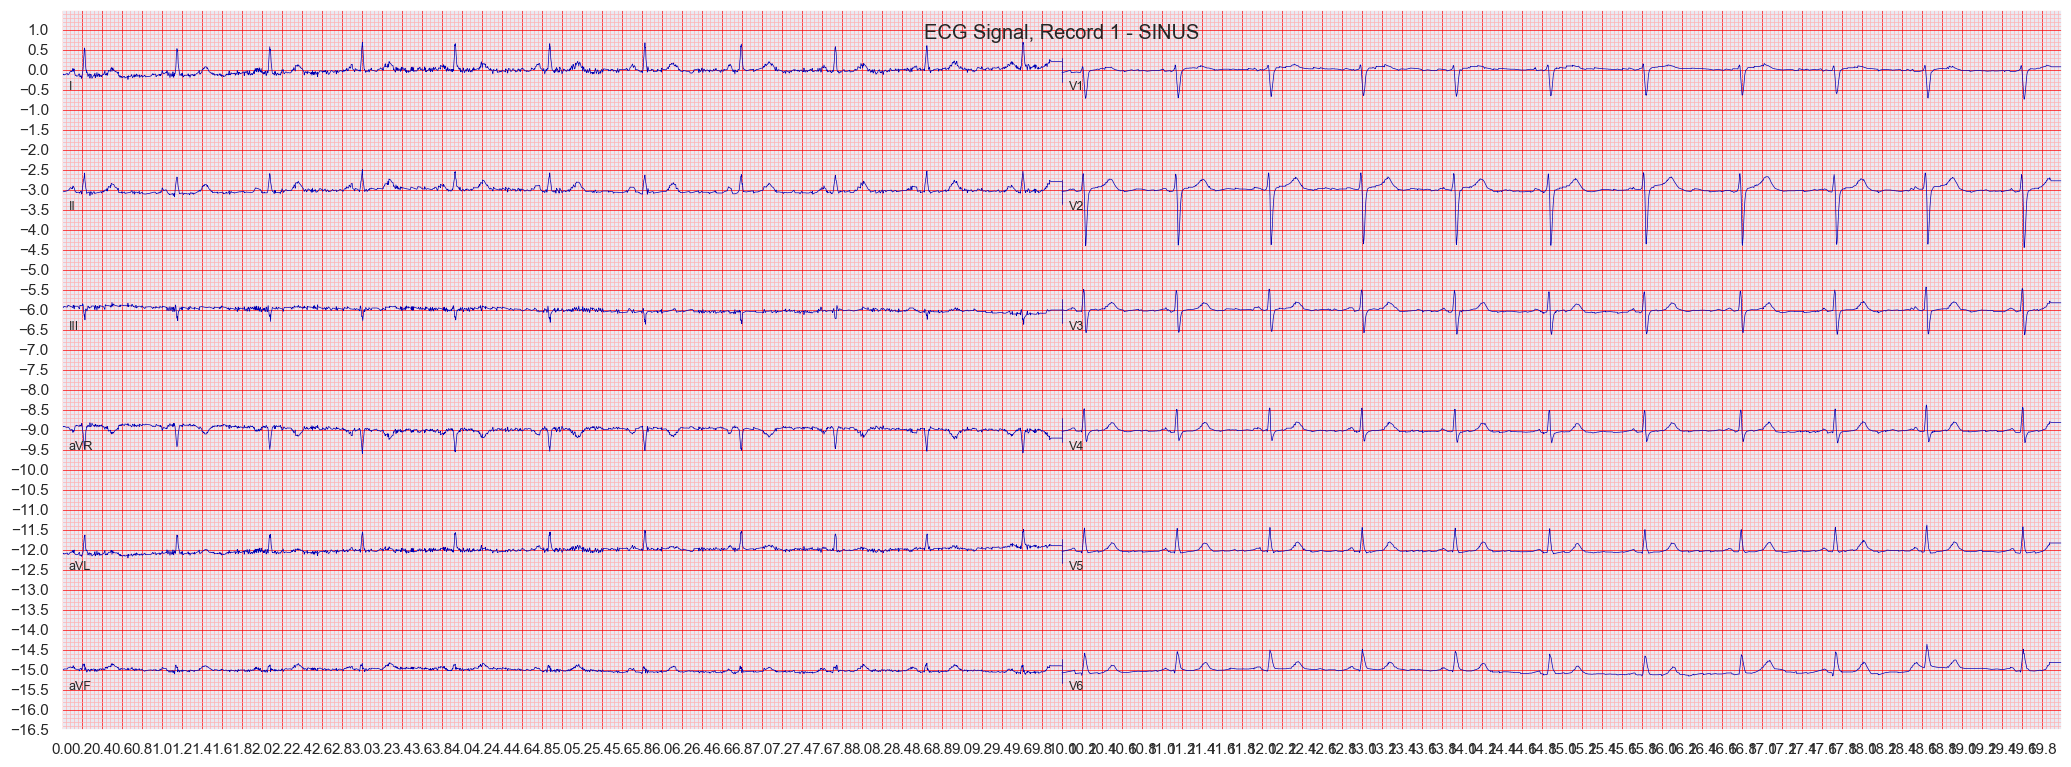

In [23]:
plot_ecg(X[0])

In [24]:
X_train, X_test, y_train, y_test = train_test_split_dataset(X, y)

In [25]:
print(X_train.shape)
X_test.shape

(17370, 5000, 12)


(4342, 5000, 12)

In [26]:
del X, y

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

In [30]:
class EcgRecordsDataset(Dataset):
    def __init__(self, train=True):
        super(EcgRecordsDataset).__init__()
        self.train = train
        if self.train:
            self.X = X_train
            self.y = y_train
        else:
            self.X = X_test
            self.y = y_test

    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, index):
        signal = torch.tensor(self.X[index], dtype=torch.float32)
        label = torch.tensor(self.y[index], dtype=torch.float32)
        return signal, label

In [31]:
ds_train = EcgRecordsDataset(train=True)
ds_val = EcgRecordsDataset(train=False)

In [32]:
batch_size = 64
num_workers = 0

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [34]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5000 * 12, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [129]:
baseline = BaselineModel()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
baseline.to(device)

BaselineModel(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=60000, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [130]:
def train_step(model, optimizer, loader, criterion):
    model.train()
    losses_train = []
    batch_accuracy = 0
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        batch_size = y_batch.shape[0]
        y_pred = model(x_batch).squeeze(1)
        loss = criterion(y_pred, y_batch)
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()
        threshold = 0.5
        answers = torch.where(y_pred > threshold, torch.tensor(1.0), torch.tensor(0.0))
        batch_accuracy += torch.mean((y_batch == answers).float())
    accuracy = batch_accuracy / len(loader)
    return model, optimizer, accuracy, np.mean(losses_train)

In [131]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(model, optimizer, train_loader, val_loader, criterion, scheduler=None, epochs=10):
    lrs = []
    accuracies = []
    losses = []
    for epoch in tqdm(range(1, epochs + 1)):
        print(f'#{epoch}/{epochs}:')
        lrs.append(get_lr(optimizer))
        model, optimizer, accuracy, loss = train_step(model, optimizer, train_loader, criterion)
        accuracies.append(accuracy.cpu())
        losses.append(loss)
        
        if scheduler:
            try:
                scheduler.step()
            except:
                scheduler.step(loss)
            
        if epoch % 10 == 0:
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(losses, label='Train Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
    
            plt.subplot(1, 2, 2)
            plt.plot(accuracies, label='Train Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            clear_output(True)
    # return accuracies

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:36<00:00,  1.68s/it]


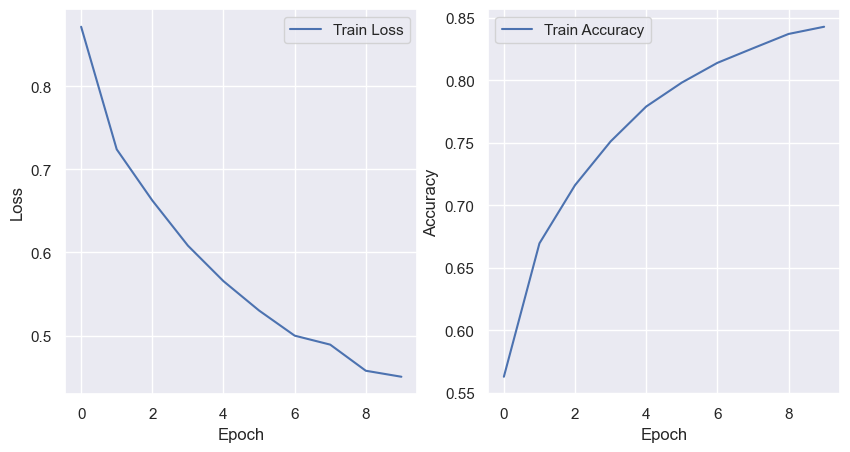

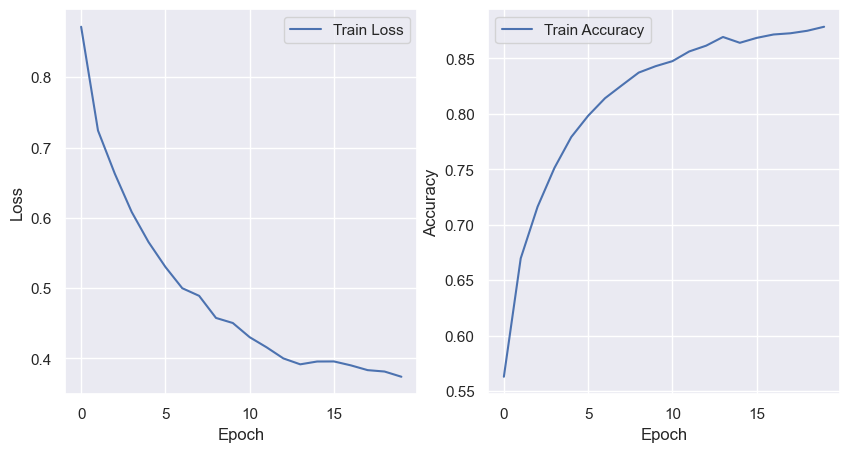

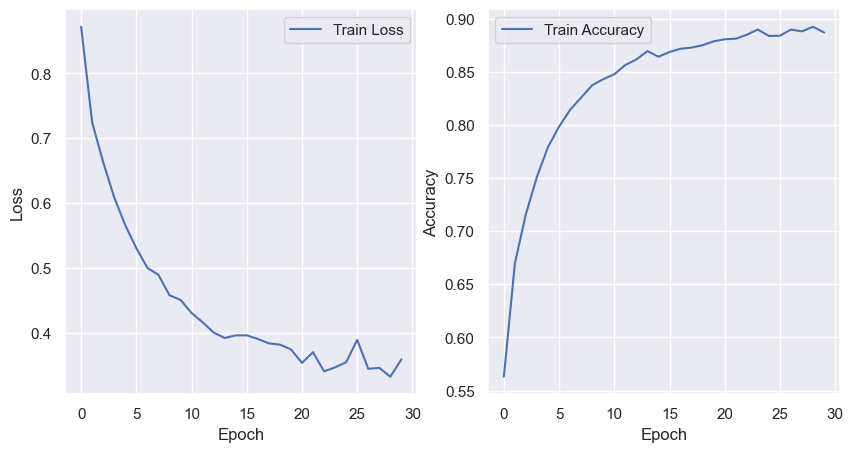

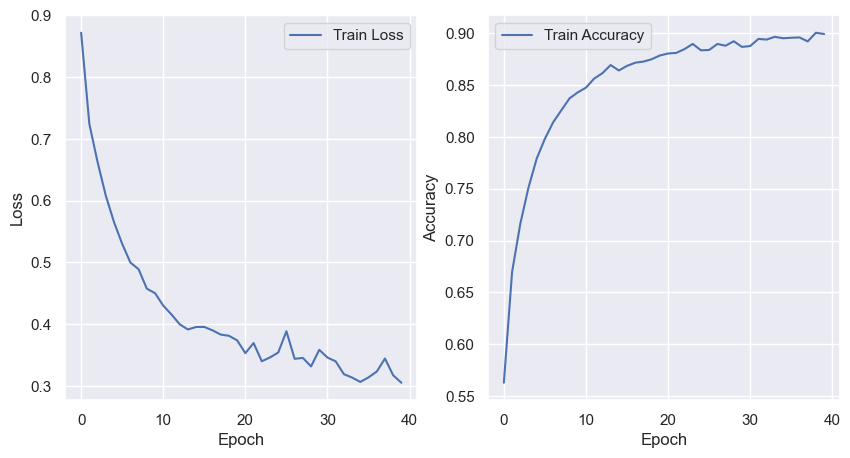

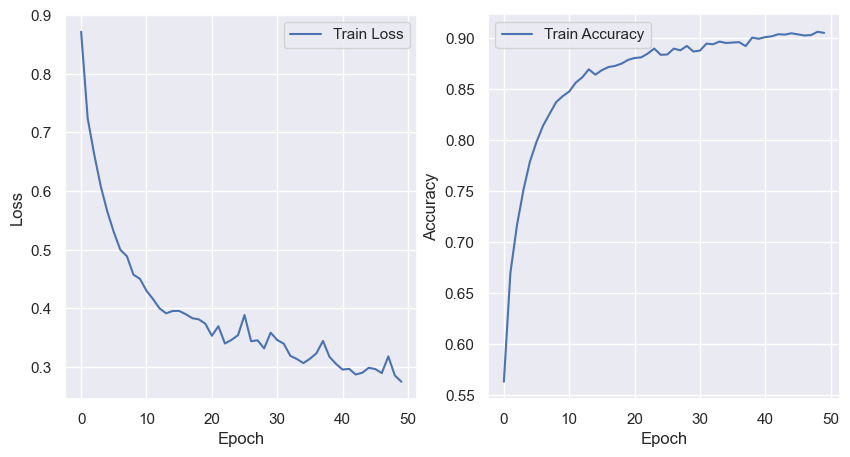

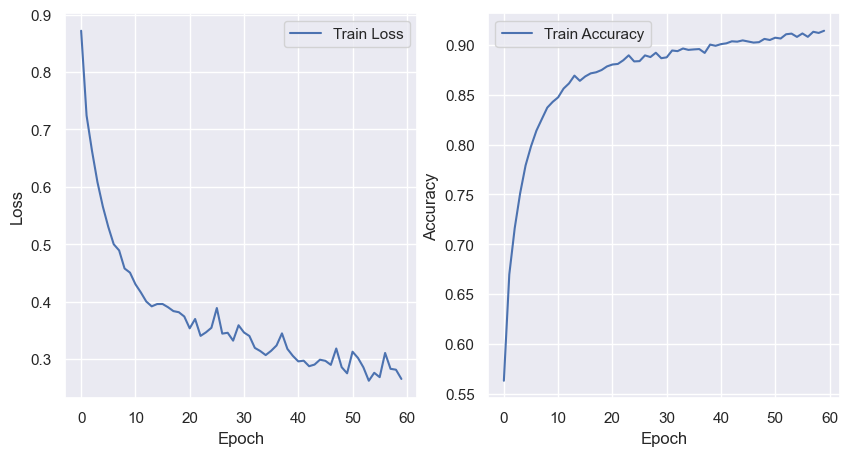

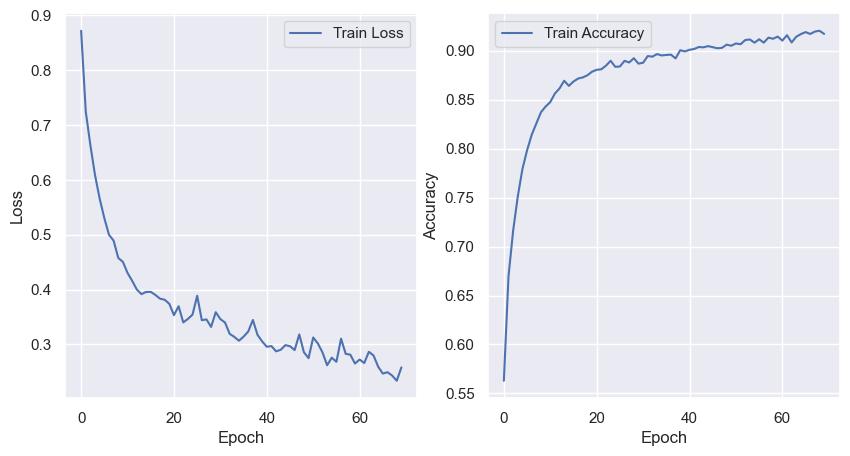

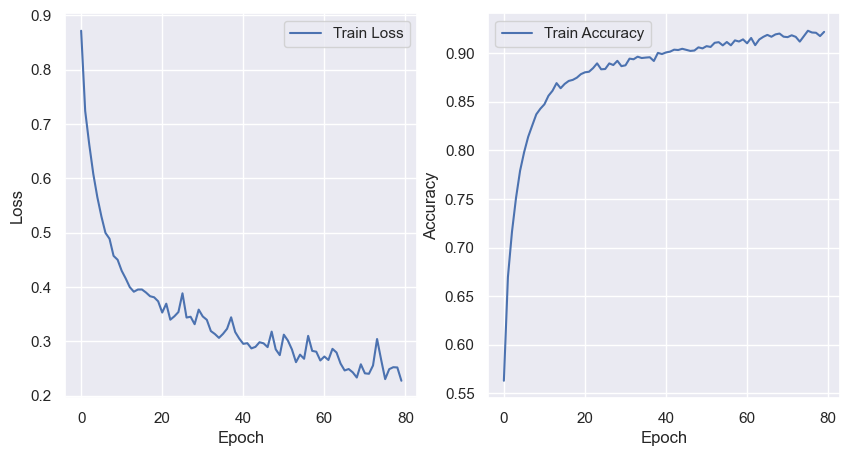

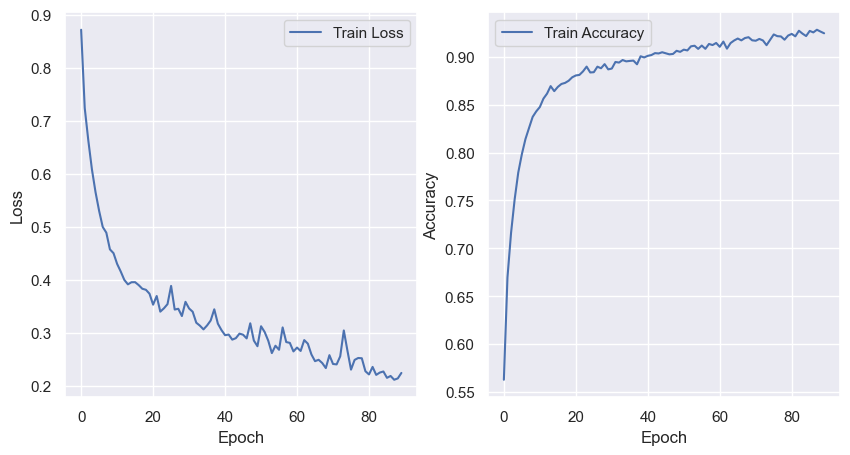

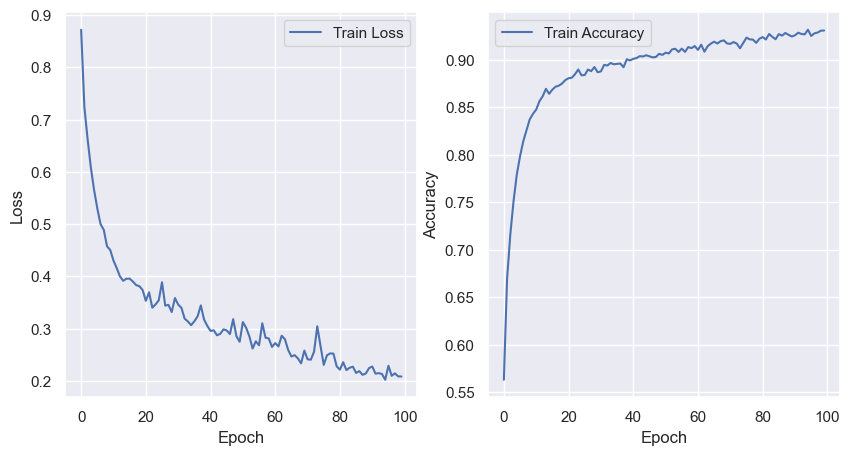

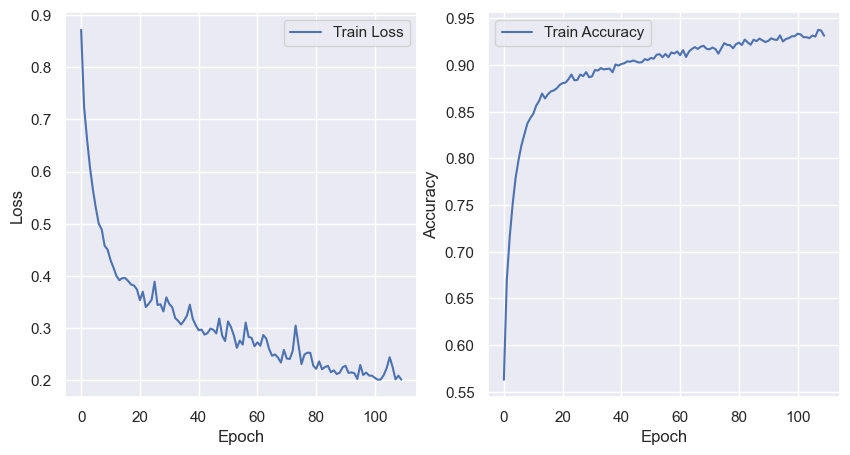

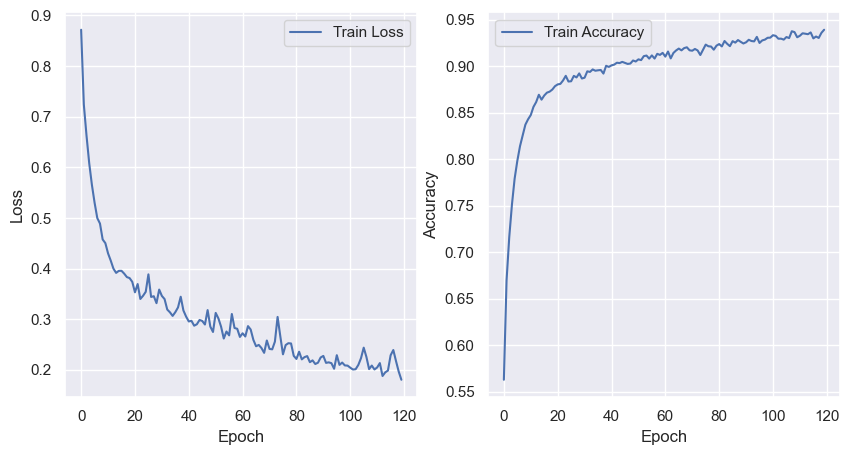

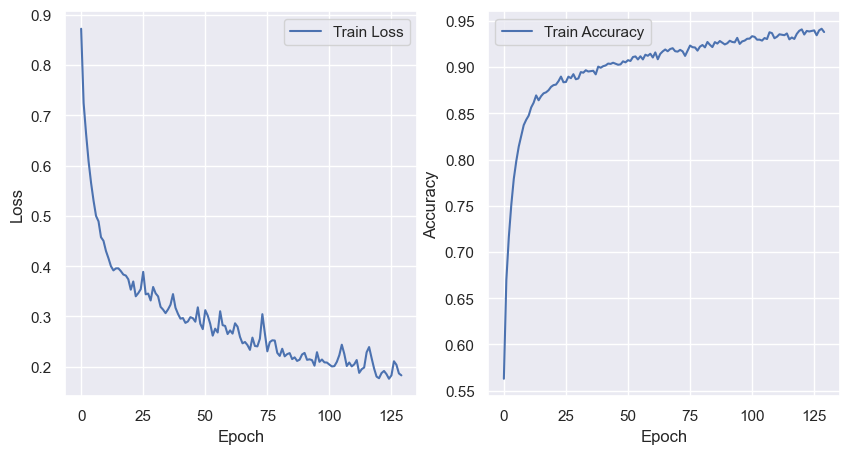

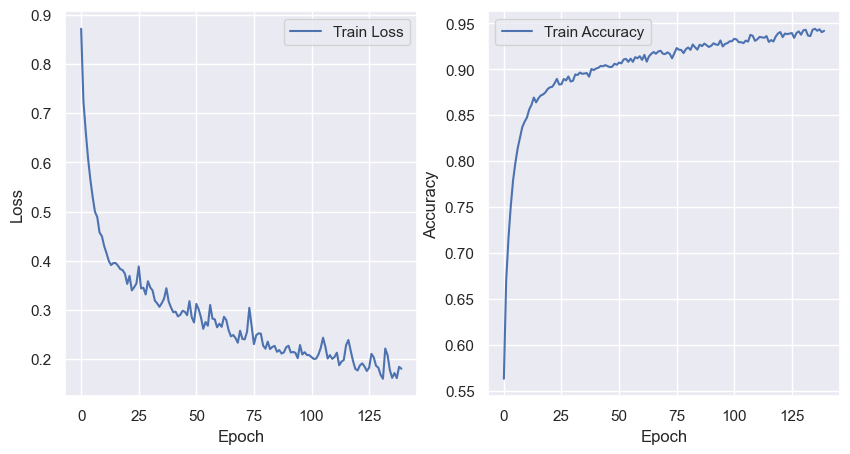

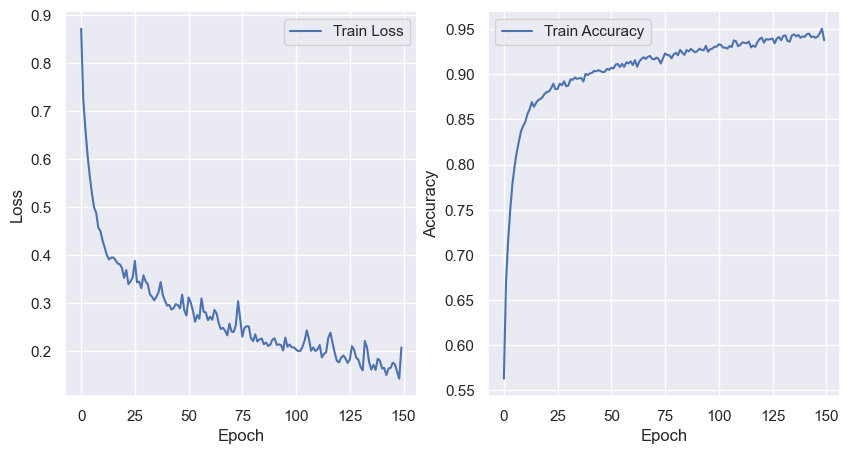

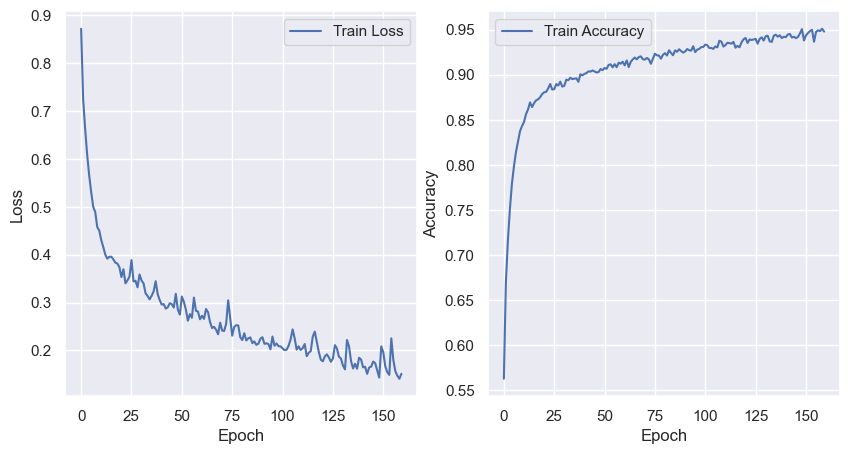

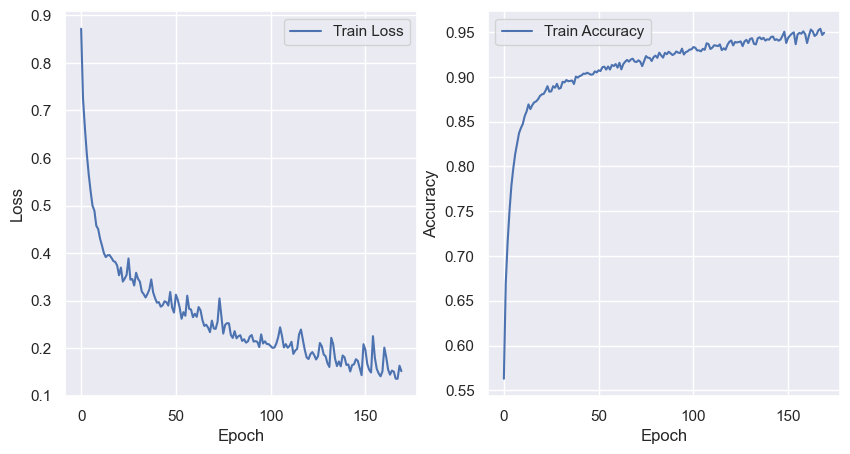

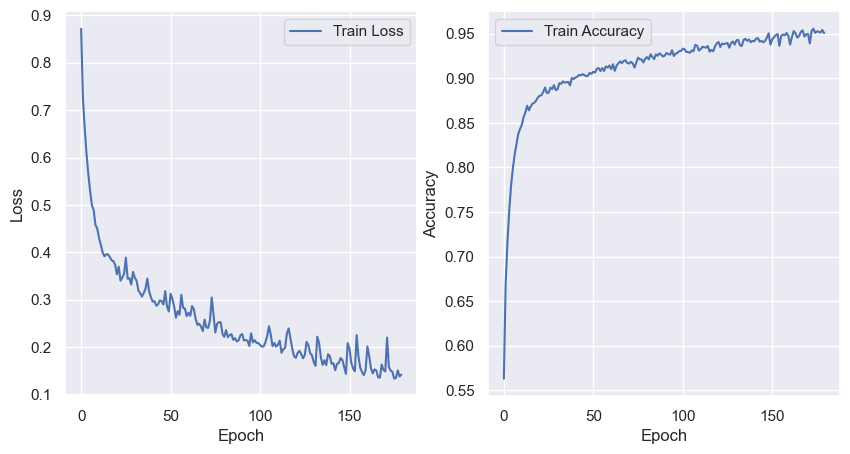

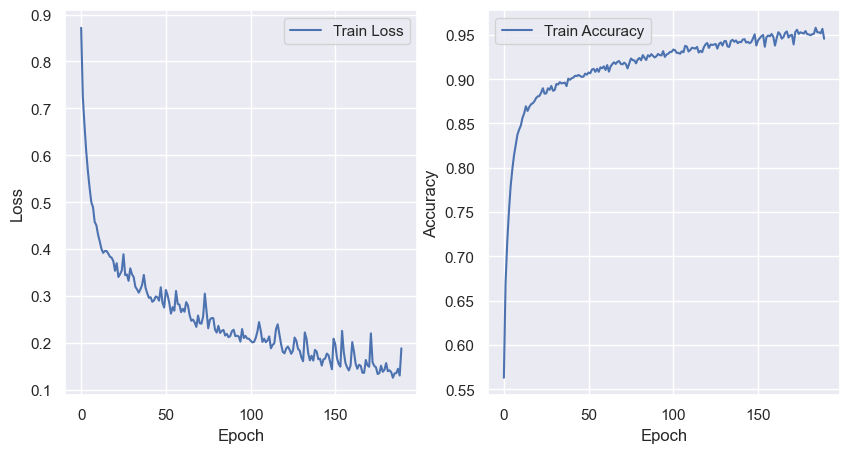

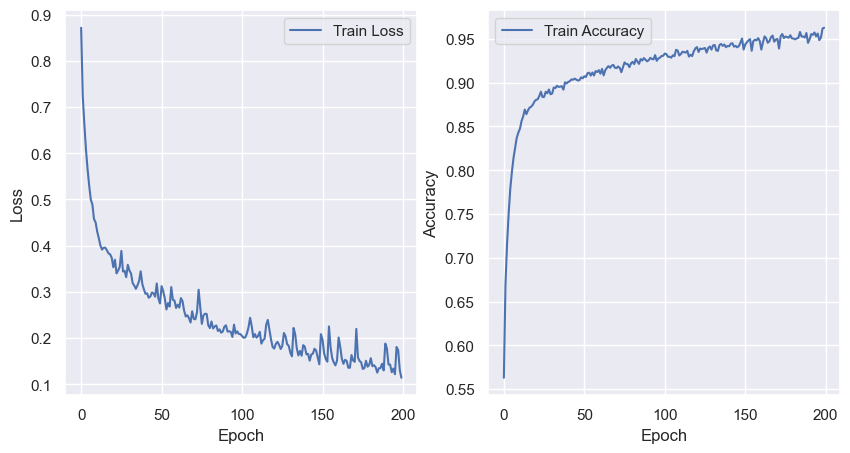

In [132]:
train(baseline, optimizer, dataloader_train, dataloader_val, criterion, scheduler, epochs=200)

In [311]:
def train_step(model, optimizer, loader, criterion):
    model.train()
    losses_history = []
    for x_batch, y_batch in tqdm(loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        batch_size = len(y_batch)
        pred = model(x_batch).squeeze(1)
        loss = criterion(pred, y_batch.float())
        loss.backward()
        optimizer.step()
        losses_history.append(loss.cpu())
    return model, optimizer, torch.mean(torch.tensor(losses_history))


def val_step(model, loader, criterion):
    model.eval()
    losses_val = []
    accuracy_val = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            batch_size = len(y_batch)
            pred = model(x_batch).squeeze(1)
            print("y_true:", y_batch)
            print("y_pred:", pred)
            loss = criterion(pred, y_batch)
            losses_val.append(loss.cpu())
            predictions = (pred > 0.5).float()
            print("predictions = ", predictions)
            correct_predictions = (predictions == y_batch.float()).float()
            print(torch.mean(correct_predictions))
            accuracy_val.append(torch.mean(correct_predictions))
    return np.mean(losses_val), torch.mean(torch.tensor(accuracy_val))

In [236]:
def train(model, optimizer, scheduler=None, n_epochs=20):
    losses_tr = []
    accuracy_tr = []
    losses_val = []
    accuracy_val = []
    for epoch in tqdm(range(n_epochs)):
        train_losses = []
        train_accuracies = []
        for x_train, y_train in dataloader_train:
            batch_size = len(y_train)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train).squeeze(1)
            loss = F.binary_cross_entropy_with_logits(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            predictions = (torch.sigmoid(y_pred) > 0.5).float()
            correct_predictions = (predictions == y_train.float())
            accuracy = correct_predictions.float().mean()
            train_accuracies.append(accuracy)
            train_losses.append(loss.item())

        # losses_tr.append(np.mean(train_losses))
        # accuracy_tr.append(np.mean(train_losses))
        losses_tr.extend(train_losses)
        accuracy_tr.extend(train_accuracies)

        if epoch % 3 == 0 and epoch != 0:
            val_losses = []
            val_accuracies = []
            with torch.no_grad():
                for x_val, y_val in dataloader_val:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(x_val).squeeze(1)
                    loss = F.binary_cross_entropy_with_logits(y_pred, y_val)
                    val_losses.append(loss.item())
                    predictions = (torch.sigmoid(y_pred) > 0.5).float()
                    correct_predictions = (predictions == y_val.float())
                    accuracy = correct_predictions.float().mean().item().cpu()
                    val_accuracies.append(accuracy)

            losses_val.append(np.mean(val_losses))
            accuracy_val.append(np.mean(val_accuracies))
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(losses_tr, label='Train Loss')
            plt.plot(losses_val, label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss Over Time')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(accuracy_tr, label='Train Accuracy')
            plt.plot(accuracy_val, label='Val Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Accuracy Over Time')
            plt.legend()

            plt.tight_layout()
            plt.show()

        # print(f"Epoch: {epoch}, loss: {np.mean(train_losses)}, accuracy: {np.mean(val_accuracy)}")

In [183]:
baseline_model = BaselineModel()
baseline_model.to(device)
summary(baseline_model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Linear: 2-2                       60,001
Total params: 60,001
Trainable params: 60,001
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Linear: 2-2                       60,001
Total params: 60,001
Trainable params: 60,001
Non-trainable params: 0

In [222]:
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)